In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rubin_sim.phot_utils as phot_utils
#%matplotlib inline
#%config InlineBackend.figure_format='retina'  

# requires openpyxl

In [2]:
df = pd.read_excel("Final M1 M2 M3 _ April 2024.xlsx")
df.sort_values(by='Wavelength (nm)', inplace=True)
df

,Wavelength (nm),M2 (average of 6 witness samples),M1M3 average (Hand-handle reflectometer - CT7),M1M3 (corrected with new target),Rubin proc-Silver min Req
800,300,33.731500,NaN,35.169635,2.0
799,301,32.647667,NaN,34.611790,NaN
798,302,32.304833,NaN,33.678802,NaN
797,303,31.130667,NaN,32.270605,NaN
796,304,29.650667,NaN,32.133058,NaN
...,...,...,...,...,...
4,1096,99.357167,NaN,99.652315,NaN
3,1097,99.353667,NaN,99.651150,NaN
2,1098,99.352833,NaN,99.656763,NaN
1,1099,99.361833,NaN,99.658036,NaN


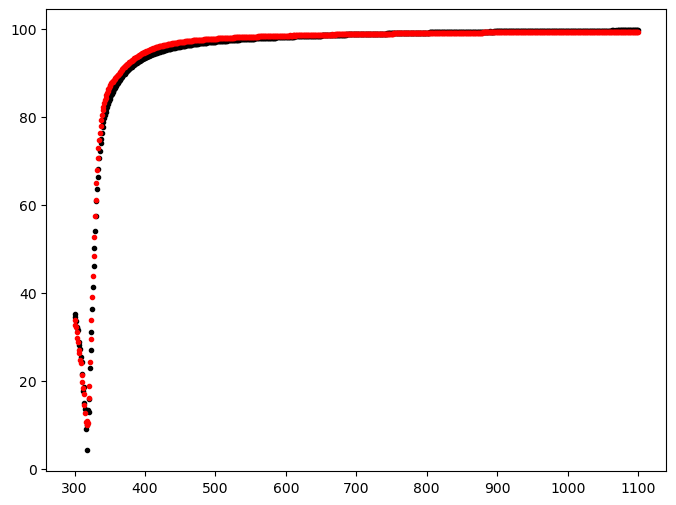

In [3]:
plt.figure(figsize=(8, 6))
plt.plot(df['Wavelength (nm)'], df['M1M3 (corrected with new target)'], 'k.')
plt.plot(df['Wavelength (nm)'], df['M2 (average of 6 witness samples)'], 'r.')

In [27]:
m1_new = phot_utils.Bandpass(wavelen=df['Wavelength (nm)'].values, sb=df['M1M3 (corrected with new target)'].values/100)
m1_new.resample_bandpass(wavelen_min=300, wavelen_max=1150, wavelen_step=0.1)
m3_new = phot_utils.Bandpass(wavelen=df['Wavelength (nm)'].values, sb=df['M1M3 (corrected with new target)'].values/100)
m3_new.resample_bandpass(wavelen_min=300, wavelen_max=1150, wavelen_step=0.1)
m2_new = phot_utils.Bandpass(wavelen=df['Wavelength (nm)'].values, sb=df['M2 (average of 6 witness samples)'].values/100)
m2_new.resample_bandpass(wavelen_min=300, wavelen_max=1150, wavelen_step=0.1)

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/phot_utils/bandpass.py:82: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [28]:
# Read current (main) throughputs
import syseng_throughputs as st
standard_dirs = st.setDefaultDirs()
standard_dirs

m1 = st.buildMirror(standard_dirs['mirror1'], addLosses=False)
m2 = st.buildMirror(standard_dirs['mirror2'], addLosses=False)
m3 = st.buildMirror(standard_dirs['mirror3'], addLosses=False)

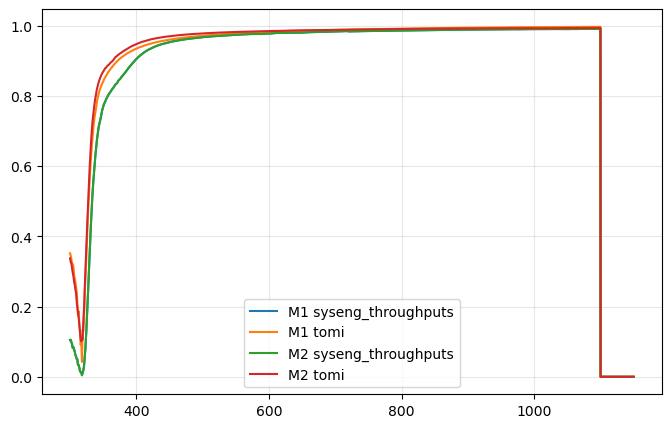

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(m1.wavelen, m1.sb, label='M1 syseng_throughputs')
plt.plot(m1_new.wavelen, m1_new.sb, label='M1 tomi')
# plt.title("M1")
# plt.legend()
# plt.figure(figsize=(8, 5))
plt.plot(m2.wavelen, m2.sb, label='M2 syseng_throughputs')
plt.plot(m2_new.wavelen, m2_new.sb, label='M2 tomi')
# plt.title("M2")
# plt.legend()
# plt.figure(figsize=(8, 5))
#plt.plot(m3.wavelen, m3.sb, label='syseng_throughputs')
#plt.plot(m3_new.wavelen, m3_new.sb, label='tomi')
#plt.title("M3")
plt.legend()
plt.grid(alpha=0.3)

In [30]:
# Build each component.
detector = st.buildDetector(standard_dirs["detector"], addLosses=False)
lens1 = st.buildLens(standard_dirs["lens1"], addLosses=False)
lens2 = st.buildLens(standard_dirs["lens2"], addLosses=False)
lens3 = st.buildLens(standard_dirs["lens3"], addLosses=False)
filters = st.buildFilters(standard_dirs["filters"], addLosses=False, shiftFilters=None)
atmosphere = st.readAtmosphere(standard_dirs["atmosphere"], atmosFile="atmos_10_aerosol.dat")

mirror1 = m1_new
mirror2 = m2_new
mirror3 = m3_new

# Combine the individual components.
core_sb = (
    detector.sb
    * lens1.sb
    * lens2.sb
    * lens3.sb
    * mirror1.sb
    * mirror2.sb
    * mirror3.sb
)
wavelen = detector.wavelen
hardware = {}
system = {}
for f in filters:
    hardware[f] = phot_utils.Bandpass()
    system[f] = phot_utils.Bandpass()
    hw_sb = core_sb * filters[f].sb
    hardware[f].set_bandpass(wavelen, hw_sb)
    system[f].set_bandpass(wavelen, hw_sb * atmosphere.sb)

In [36]:
m5_new = st.makeM5(hardware, system)
m5_new

,nexp,exptime,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,1.0,30.0,0.92,0.80824,23.019739,78.494868,27.075466,0.038093,0.059459,0.483423,0.037794,23.414254,0.379692,0.225514,24.127399,453.260528,23.9,23.4
g,2.0,15.0,0.87,0.76714,22.262303,586.790927,28.770529,0.181500,0.221252,0.215029,0.038898,24.673213,0.129582,0.066387,25.068312,907.837532,25.0,24.6
r,2.0,15.0,0.83,0.73426,21.197321,1219.994086,28.588927,0.153545,0.172492,0.126335,0.039148,24.694515,0.066498,0.031985,24.608226,1173.280961,24.7,24.3
i,2.0,15.0,0.80,0.70960,20.462362,1970.487603,28.405065,0.129625,0.141580,0.095778,0.039287,24.644430,0.042215,0.019393,24.230631,1402.474045,24.0,23.6
z,2.0,15.0,0.78,0.69316,19.606544,2952.743188,28.015741,0.090565,0.096455,0.068414,0.039394,24.478734,0.028578,0.012553,23.664515,1650.486194,23.3,22.9
y,2.0,15.0,0.76,0.67672,18.601770,3359.994948,27.048541,0.037160,0.043504,0.171123,0.039415,23.947478,0.025201,0.010848,22.659075,1709.651584,22.1,21.7


In [37]:
hardware_default, system_default = st.buildHardwareAndSystem(standard_dirs, atmosphereOverride=atmosphere, addLosses=False)
m5_default = st.makeM5(hardware_default, system_default)
m5_default

,nexp,exptime,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,1.0,30.0,0.92,0.80824,23.053530,57.773834,26.790100,0.029289,0.045147,0.469805,0.037642,23.184140,0.466612,0.287032,23.914180,424.120273,23.9,23.4
g,2.0,15.0,0.87,0.76714,22.257456,569.286136,28.734035,0.175500,0.213696,0.213795,0.038886,24.651823,0.133081,0.068350,25.044498,897.296512,25.0,24.6
r,2.0,15.0,0.83,0.73426,21.197374,1201.854359,28.572724,0.151270,0.169935,0.126327,0.039142,24.685386,0.067436,0.032475,24.599123,1165.632399,24.7,24.3
i,2.0,15.0,0.80,0.70960,20.462610,1941.132431,28.389031,0.127725,0.139503,0.095764,0.039282,24.635732,0.042826,0.019700,24.222058,1392.869631,24.0,23.6
z,2.0,15.0,0.78,0.69316,19.606469,2909.090504,27.999499,0.089220,0.095023,0.068410,0.039390,24.470135,0.028994,0.012756,23.655879,1638.964137,23.3,22.9
y,2.0,15.0,0.76,0.67672,18.601665,3311.488074,27.032686,0.036622,0.042872,0.171084,0.039411,23.939151,0.025560,0.011022,22.650695,1697.920902,22.1,21.7


In [39]:
m5_new['m5'] - m5_default['m5']

u    0.213219
g    0.023814
r    0.009103
i    0.008574
z    0.008636
y    0.008380
Name: m5, dtype: float64

In [43]:
# Write the new mirror reflectivities into the repository

header = '#Wavelength(nm)   Throughput(0-1)\n'

with open(os.path.join(standard_dirs['mirror1'], 'm1_ProtAg.dat'), 'w') as file:
    file.write(header)
    for i in range(len(m1_new.wavelen)):
        file.write("%.4e\t%.4e\n"%(m1_new.wavelen[i], m1_new.sb[i]))

with open(os.path.join(standard_dirs['mirror3'], 'm3_ProtAg.dat'), 'w') as file:
    file.write(header)
    for i in range(len(m3_new.wavelen)):
        file.write("%.4e\t%.4e\n"%(m3_new.wavelen[i], m3_new.sb[i]))

with open(os.path.join(standard_dirs['mirror2'], 'm2_ProtAg.dat'), 'w') as file:
    file.write(header)
    for i in range(len(m2_new.wavelen)):
        file.write("%.4e\t%.4e\n"%(m2_new.wavelen[i], m2_new.sb[i]))